In [1]:
## some referemces: 
## https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.5.043175
## https://arxiv.org/pdf/quant-ph/0003137 
## https://quantum-journal.org/papers/q-2021-07-26-509/pdf/

import time as tt
import numpy as np # type: ignore
import matplotlib.pyplot as pl # type: ignore
# from numba import njit, prange

## Complete construction ##

In [106]:
def config_state(lisst):
    L = len(lisst)
    bits = [[1,0],[0,1]]
    out = [1]
    for x in lisst:
        out= np.kron(out, bits[np.mod(x,2)])
    return out


def fc(a,j,L):
    j = np.mod(j,L)
        
    spin = np.array([[0,1],[1,0]]), np.array([[0,-1j],[+1j,0]])#, np.array([[1,0],[0,-1]]) 
    out = [1]
    for _ in range(j):
        # out = np.kron(out,spin[2])
        out = np.kron(out,[ 1, -1])
        
    op = 0.5*(spin[0]+a*1j*spin[1])
    out = np.kron(np.diag(out), np.kron(op, np.eye(2**(L-j-1)))) # out = np.kron(out, np.kron(op, np.eye(2**(L-j))))
    return out ##np.kron(np.diag(out), np.kron(op, np.eye(2**(L-j))))


def hoping_gate(indx1, indx2, L, parametrs):
    th1,th2,th3,th4 = parametrs[:4]
    
    op1 = (th3-1j*th4)*fc(+1,indx1,L) @ fc(-1,indx2, L) # maybe just th1
    op2 = (th3+1j*th4)*fc(+1,indx2,L) @ fc(-1,indx1,L)
    op3 = th1*fc(+1,indx1,L) @ fc(-1,indx1, L) # maybe th3*(n_1 - n_2) like the paper
    op4 = th2*fc(+1,indx2,L) @ fc(-1,indx2,L)
    
    OP = op1+op2+op3+op4    

    evals, evect = np.linalg.eigh(OP)
    
    output = np.linalg.multi_dot([evect, np.diag(np.exp( - 1j * evals )), np.conjugate(np.transpose(evect)) ])
    
    return output


def inter_gate(indx1, indx2, L, parametrs):
    
    th1 = parametrs[:1]
    
    OP = th1 * fc(+1,indx1,L) @ fc(-1,indx1,L) @ fc(+1,indx2, L) @ fc(-1,indx2, L)
    
    evals, evect = np.linalg.eigh(OP)
    
    output = np.linalg.multi_dot([evect, np.diag(np.exp( - 1j * evals )), np.conjugate(np.transpose(evect)) ])
    
    return output


def fermioin_quantum_circuit(geometrical, parameter, **kws):
    
    PBC = kws['PBC'] if 'PBC' in kws.keys() else True
    N_layer, L = geometrical[:2]
    
    parameter = np.reshape(parameter, (N_layer*(L-int(not PBC)),4))
    
    # ini_state = config_state([0,1]*(L//2)) # 
    ini_state = np.array( [1]+[0]*(2**L-1) )

    for nl in range(N_layer):
        # print("--------", nl,"---------")
        
        # testvec = []
        odd_ops = np.eye(2**(L))
        for ei in range(L//2):        
            odd_ops = odd_ops @ hoping_gate(2*ei,2*ei+1, L, parameter[ ei + nl*(L-1), : ])    
            # testvec.append([2*ei,2*ei+1])
            # print("[",2*ei,"",2*ei+1,"]")
        # print(testvec)
        # ini_state = odd_ops @ ini_state    
        # testvec = []
        even_ops = np.eye(2**(L))
        for ei in range(L//2-int(not PBC)):        
            even_ops = even_ops @ hoping_gate(2*ei+1,2*ei+2, L, parameter[ ei + nl*(L-1) + L//2, : ])
            # testvec.append([2*ei+1,2*ei+2])
            # print("[",2*ei+1,"",2*ei+2,"]")
        # print(testvec)
            
        ini_state = even_ops @ odd_ops @ ini_state
        # print("--------", nl+1,"---------")
    return ini_state


def fermion_correlation(input_state, L, **kws):
    
    out = np.zeros((L,L), dtype=np.complex_)
    
    for n in range(L):
        for m in range(L):
            out[n,m] += input_state.T.conj() @ fc(+1,n,L) @ fc(-1,m,L) @ input_state
    return out 


def fermion_energy(input_mat, L, physical, **kws):
    
    V,J = physical[:2]    
    
    PBC = kws['PBC'] if 'PBC' in kws.keys() else True

    
    out=0
    for n in range(L - int(not PBC)):
        out += -J*(input_mat[np.mod(n,L), np.mod(n+1,L)] + input_mat[np.mod(n+1,L), np.mod(n,L)]) 
        # out += -J*fc(+1,n+1,L) @ fc(-1,n,L)
        out += -0.5*V*( input_mat[np.mod(n,L), np.mod(n,L)]*input_mat[np.mod(n+1,L), np.mod(n+1,L)] - input_mat[np.mod(n,L), np.mod(n+1,L)]*input_mat[np.mod(n+1,L), np.mod(n,L)] )
    
    return out


######################################################################## UNTIL HERE IT WORKS ###################################################################################

def grad_desc(input_data, function, **kws):
    
    shift = kws['p_shift'] if 'p_shift' in kws.keys() else 0.001

    sizes = input_data.shape
    gradient = np.zeros(sizes, dtype=np.float64)
    
    # for indx in np.ndindex(sizes):
    for indx in range(sizes[0]*sizes[1]):
        input_data[indx] += shift
        en1 = function(input_data)
        input_data[indx] += -shift
        en2 = function(input_data)
        
        diff = (en1-en2)/(2*shift)
        input_data[indx] += 2*shift
    
    
    return gradient


def fermioin_VQE(physical, geometrical,**kws):

    PBC = kws['PBC'] if 'PBC' in kws.keys() else True

    N_layer, L = geometrical[:2]
    parametrs = np.random.randn(N_layer*(L -int(not PBC)),4)
    
    return


# def full_total_particle_counts(L):
    
#     out = np.zeros((2**L,2**L), dtype=np.complex_)  
#     for n in range(1,L+1):    
#         out += fc(+1,n,L) @ fc(-1,n,L)     
    
#     return out


# def full_particle_counts(input_state,L):
    
#     input_state = np.array(input_state)
#     # N = np.zeros((2**L,2**L), dtype=np.complex_) 
#     Ns = np.zeros((L,) ) 
#     for n in range(1,L+1):    
#         n_th = fc(+1,n,L) @ fc(-1,n,L) 
#         Ns[int(n-1)] += input_state @ n_th @ input_state.conj()
        
#     return Ns

NN,LL = 1,4
# params = np.zeros((NN*LL,4))
params = np.random.randn(NN*LL,4)
# ss = fermioin_quantum_circuit([NN,LL],params)
# print(ss.conj() @ ss," - ", ss)
print("")
# cors = fermion_correlation(ss,(NN,LL))
# print(cors-cors.T.conj())
print("")
# fe = fermion_energy(cors,(NN,LL),(1,3))
# print(fe)
# para = np.zeros((3,4))
# ss = hoping_gate(0,1,3,para[0,:])
# print(ss)
# ss = config_state([0,1]*(LL//2))
# len(ss)

## Modular construction 1D

In [ ]:

def modul_hoping_gate(parametrs):

    th1,th2,th3,th4 = parametrs[:4]    
    # evals, evect = np.linalg.eigh(OP)
    # output = np.linalg.multi_dot([evect, np.diag(np.exp( - 1j * evals )), np.conjugate(np.transpose(evect)) ])
    # return np.array([[th1,th3],[th3,th2]])

    return np.array([[th1,th3+1j*th4],[th3-1j*th4,th2]])



def modul_circuit_correlation(parameters, geometrical, **kws):
    
    PBC = kws['PBC'] if 'PBC' in kws.keys() else True

    N_layer, L = geometrical[:2]
    parameters = np.reshape(parameters, (N_layer*(L-int(not PBC)),4) )
    
    CIRC_MAT = np.eye(L)
    OUT_COR = np.diag([1,0]*(L//2)) 
    # OUT_COR = np.diag([1]+[0]*(L-1)) 
    
    for nl in range(N_layer):
        C_MAT_O = np.zeros((L,L), dtype=np.complex64)
        for oi in range(L//2):
            # print("odd gate ", oi)
            C_MAT_O[2*oi:2*oi+2,2*oi:2*oi+2] = modul_hoping_gate(parameters[oi+nl*(L-int(not PBC))])
        # C_MAT_O = C_MAT_O / L #np.sqrt(L)
        val_O, vec_O = np.linalg.eigh(C_MAT_O / 1.0)
        OP_O = np.linalg.multi_dot([vec_O, np.diag(np.exp( + 1j * val_O )), np.conjugate(np.transpose(vec_O)) ])
        # print(" - - - ")
        # print(np.linalg.norm(val_O))
        
        C_MAT_E = np.zeros((L,L), dtype=np.complex64)
        for ei in range(L//2 - 1):
            # print("even gate ", ei)
            C_MAT_E[2*ei+1:2*ei+3,2*ei+1:2*ei+3] = modul_hoping_gate(parameters[ei+nl*(L-int(not PBC))+L//2])
            
        if PBC:
            C_MAT_E[::L-1,::L-1] = modul_hoping_gate(parameters[L+nl*(L-1)-1])
        # print(C_MAT_E)
        # C_MAT_E = C_MAT_E / L
        val_E, vec_E = np.linalg.eigh(C_MAT_E / 1.0)
        OP_E = np.linalg.multi_dot([vec_E, np.diag(np.exp( + 1j * val_E )), np.conjugate(np.transpose(vec_E)) ])
        # print(" - - - ")
        
        CIRC_MAT = OP_E @ OP_O @ CIRC_MAT
        # CIRC_MAT = CIRC_MAT @ OP_O @ OP_E
        
    OUT_COR = np.linalg.multi_dot([CIRC_MAT, OUT_COR, np.conjugate(np.transpose(CIRC_MAT)) ])
    
    return OUT_COR 



def fullenergy_QC_1d(input_mat, L, physical, **kws):
    
    V, J = physical[:2]    
    
    PBC = kws['PBC'] if 'PBC' in kws.keys() else True
    
    out=0
    for n in range(L - int(not PBC)):
        out += -J*(input_mat[np.mod(n,L), np.mod(n+1,L)] + input_mat[np.mod(n+1,L), np.mod(n,L)]) 
        out += -0.5*V*( input_mat[np.mod(n,L), np.mod(n,L)]*input_mat[np.mod(n+1,L), np.mod(n+1,L)] - input_mat[np.mod(n,L), np.mod(n+1,L)]*input_mat[np.mod(n+1,L), np.mod(n,L)] )
    return out



def GetGradian_QC_1d(input_array, physical, geometrical, **kw):
    
    shift = kw['p_shift'] if 'p_shift' in kw.keys() else 0.001
    
    _, L = geometrical[:2]
    
    grad_array = np.zeros(input_array.shape)
    for i_th in range(input_array.size):
        input_array[i_th] += shift
        C_mat1 = modul_circuit_correlation(input_array, geometrical, **kw)
        energi1 = fullenergy_QC_1d(C_mat1, L, physical, **kw)
        
        input_array[i_th] += -2 * shift
        C_mat2 = modul_circuit_correlation(input_array, geometrical, **kw)
        energi2 = fullenergy_QC_1d(C_mat2, L, physical, **kw)
        
        grad_array[i_th] += np.real((energi1-energi2)/(2*shift))
        # print(" - - - ", (energi1-energi2)/(2*shift))
        input_array[i_th] += shift
        
    return(grad_array)



def fermion_VQE_1d(physical, geometrical, **kws):
    
    grad_rate = kws['grad_rate'] if 'grad_rate' in kws.keys() else 0.1357
    max_iter = kws['max_iter'] if 'max_iter' in kws.keys() else 200
    PBC = kws['PBC'] if 'PBC' in kws.keys() else True
    print("- - func")
    
    # # print("")    # print("- - ", energy)
    N_layer, L = geometrical[:2]
    parameters = 0.1*np.random.randn(N_layer*(L-int(not PBC))*4)
    
    Energy = []    
    for itr in range(max_iter):
        
        c_mat = modul_circuit_correlation(parameters, geometrical,**kws)
        energy = fermion_energy(c_mat,L,physical, **kws)
        Energy.append(energy.real)
        # print(energy)
        # print("")
        
        # shift = 0.001
        # grad_desc = np.zeros(parameters.shape, dtype=np.float64)
        # for indx in range(parameters.size):
        #     parameters[indx] += shift
        #     c_mat1 = modul_circuit_correlation(parameters, geometrical,**kws)
        #     energ1 = fermion_energy(c_mat1, L, physical, **kws)
            
        #     parameters[indx] += -2*shift
        #     c_mat2 = modul_circuit_correlation(parameters, geometrical,**kws)
        #     energ2 = fermion_energy(c_mat2, L, physical, **kws)

        #     grad_desc[indx] += (energ1-energ2)/(2*shift)
        #     parameters[indx] += shift
        
        grad_desc = GetGradian_QC_1d(parameters, physical,geometrical,**kws)
        parameters += -1 * grad_rate * grad_desc
    
    XX = np.reshape(parameters,(N_layer*L,4))
    print(XX)
    return(Energy)
    # return(circ_cmat)



<function matplotlib.pyplot.show(close=None, block=None)>

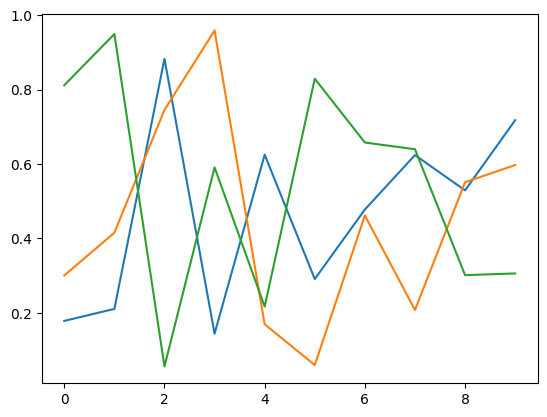

In [ ]:

LL=4
NN=1

# es = fermion_VQE_1d([1.,1.],[2,4])
# print(es[-1])
nn = np.arange(10)
es=np.random.rand(10)
ess=np.random.rand(10)
esss=np.random.rand(10)

pl.plot(nn,es)
pl.plot(nn,ess)
pl.plot(nn,esss)
pl.show


## Modular construction 2D

In [2]:

def modul_hoping_gate(parametrs):

    th1,th2,th3,th4 = parametrs[:4]    

    return np.array([[th1,th3+1j*th4],[th3-1j*th4,th2]])



def modul_circuit_2d(parameters, geometrical, **kws):
    
    PBC = kws['PBC'] if 'PBC' in kws.keys() else True

    Lx, Ly, N_layer = geometrical[:3] #convesion is Lx, Ly, N_layer
    
    L = Lx*Ly
    num_gates = Lx*(Ly-int(not PBC))+Ly*(Lx-int(not PBC))
    
    param_shap = (N_layer * num_gates, 4)
    parameters = np.reshape(parameters, param_shap)
    
    CIRC_MAT = np.eye(Lx*Ly)
    OUT_COR = np.kron(np.diag([1,0]*(Ly//2)), np.diag([1,0]*(Lx//2))) + np.kron(np.diag([0,1]*(Ly//2)), np.diag([0,1]*(Lx//2))) 
    # OUT_COR = np.diag([1]+[0]*(Lx*Ly-1)) 
    
    norm = 1.0
    for nl in range(N_layer):
        C_MAT_1 = np.zeros((L,L), dtype=np.complex64)
        for l1 in range(L//2):
            C_MAT_1[2*l1:2*l1+2,2*l1:2*l1+2] = modul_hoping_gate(parameters[l1+nl*num_gates ])
        val_1, vec_1 = np.linalg.eigh(C_MAT_1 / norm)
        OP_1 = np.linalg.multi_dot([vec_1, np.diag(np.exp( + 1j * val_1 )), np.conjugate(np.transpose(vec_1)) ])
        
        C_MAT_2 = np.zeros((L,L), dtype=np.complex64)
        for y in range(Ly):
            for x in range(Lx//2-1):
                idxs = np.ix_([2*x+y*Lx +1, 2*x+y*Lx +2], [2*x+y*Lx +1, 2*x+y*Lx +2])
                C_MAT_2[idxs] = modul_hoping_gate(parameters[x + y*(Lx//2-1) + nl*num_gates + L//2])
        if PBC:
            for y in range(Ly):
                idxs = np.ix_([y*Lx+Lx-1, y*Lx], [y*Lx+Lx-1, y*Lx])
                C_MAT_2[idxs] = modul_hoping_gate(parameters[y + nl*num_gates + L//2 + Ly])
        val_2, vec_2 = np.linalg.eigh(C_MAT_2 / norm)
        OP_2 = np.linalg.multi_dot([vec_2, np.diag(np.exp( + 1j * val_2 )), np.conjugate(np.transpose(vec_2)) ])

        C_MAT_3 = np.zeros((L,L), dtype=np.complex64)
        for y in range(Ly//2):
            for x in range(Lx):
                idxs = np.ix_([2*Lx*y+x, 2*Lx*y+x+Lx], [2*Lx*y+x, 2*Lx*y+x+Lx])
                C_MAT_3[idxs] = modul_hoping_gate(parameters[x + y*(Lx) + nl*num_gates + L])
        val_3, vec_3 = np.linalg.eigh(C_MAT_3 / norm)
        OP_3 = np.linalg.multi_dot([vec_3, np.diag(np.exp( + 1j * val_3 )), np.conjugate(np.transpose(vec_3)) ])
                
        C_MAT_4 = np.zeros((L,L), dtype=np.complex64)
        for y in range(Ly//2-1):
            for x in range(Lx):
                idxs = np.ix_([Lx+x, 2*Lx+x], [Lx+x, 2*Lx+x])
                C_MAT_4[idxs] = modul_hoping_gate(parameters[x + y*(Lx) + nl*num_gates + 3*L//2])
        if PBC:
            for x in range(Lx):
                idxs = np.ix_([(Ly-1)*Lx+x, x], [(Ly-1)*Lx+x, x])
                C_MAT_4[idxs] = modul_hoping_gate(parameters[x + nl*num_gates + 3*L//2 + Ly])
        val_4, vec_4 = np.linalg.eigh(C_MAT_4 / norm)
        OP_4 = np.linalg.multi_dot([vec_4, np.diag(np.exp( + 1j * val_4 )), np.conjugate(np.transpose(vec_4)) ])
        
        CIRC_MAT = OP_4 @ OP_3 @OP_2 @ OP_1 @ CIRC_MAT # CIRC_MAT = CIRC_MAT @ OP_O @ OP_E
        
    OUT_COR = np.linalg.multi_dot([CIRC_MAT, OUT_COR, np.conjugate(np.transpose(CIRC_MAT)) ])
    
    return OUT_COR 



# def fullenergy_QC_2d(input_C, physical, geometrical, **kws):
    
#     PBC = kws['PBC'] if 'PBC' in kws.keys() else True
    
#     Vs, J = physical[:2]
#     Lx, Ly = geometrical[:2]
    
#     ad_X = np.eye(Lx, k=1) + np.eye(Lx, k=-1)  + int(PBC)*np.eye(Lx, k=Lx-1)  + int(PBC)*np.eye(Lx, k=-Lx+1)    
#     if Ly==2:
#         ad_Y = np.eye(Ly, k=1) + np.eye(Ly, k=-1)
#     else:
#         ad_Y = np.eye(Ly, k=1) + np.eye(Ly, k=-1)  + int(PBC)*np.eye(Ly, k=Ly-1)  + int(PBC)*np.eye(Ly, k=-Ly+1)

#     ad_mat = np.kron(ad_Y, np.eye(Lx)) + np.kron(np.eye(Ly), ad_X)
    
#     E = 0
#     for xx in range(Lx*Ly):
#         for yy in range(xx,Lx*Ly):
#             E += - J*ad_mat[xx,yy] * (input_C[xx,yy] + input_C[yy,xx])
#             E += + Vs/2*ad_mat[xx,yy] * (input_C[xx,yy]*input_C[yy,xx] - input_C[xx,xx]*input_C[yy,yy])
#             # E += - Vs/2*ad_mat[xx,yy] * C[xx,xx]*C[yy,yy]
#     return(E)


def fullenergy_QC_2d(input_C, physical, geometrical, **kws): # new and fast
    
    PBC = kws['PBC'] if 'PBC' in kws.keys() else True
    
    Vs, J = physical[:2]
    Lx, Ly = geometrical[:2]
    
    ad_X = np.eye(Lx, k=1) + np.eye(Lx, k=-1)  + int(PBC)*np.eye(Lx, k=Lx-1)  + int(PBC)*np.eye(Lx, k=-Lx+1)    
    ad_Y = np.eye(Ly, k=1) + np.eye(Ly, k=-1)  + int(PBC)*np.eye(Ly, k=Ly-1)  + int(PBC)*np.eye(Ly, k=-Ly+1)
    ad_mat = np.kron(ad_Y, np.eye(Lx)) + np.kron(np.eye(Ly), ad_X)
    
    if Lx ==2 or Ly ==2:
        ad_mat = np.where(ad_mat,1,0)
    
    matJ = input_C + np.transpose(input_C)
    matV1 = np.outer(np.diag(input_C), np.diag(input_C))
    matV2 = input_C * np.transpose(input_C)

    E_mat = np.where(ad_mat, -J*matJ -(Vs/2)*matV1 +(Vs/2)*matV2, 0.0)
    
    return(np.sum(E_mat)/2)



def GetGradian_QC_2d(input_array, physical, geometrical, **kw):
    
    shift = kw['p_shift'] if 'p_shift' in kw.keys() else 0.001
        
    grad_array = np.zeros(input_array.shape)
    for i_th in range(input_array.size):
        input_array[i_th] += shift
        C_mat1 = modul_circuit_2d(input_array, geometrical, **kw)
        energi1 = fullenergy_QC_2d(C_mat1, physical, geometrical, **kw)
        
        input_array[i_th] += -2 * shift
        C_mat2 = modul_circuit_2d(input_array, geometrical, **kw)
        energi2 = fullenergy_QC_2d(C_mat2, physical, geometrical, **kw)
        
        grad_array[i_th] += np.real((energi1-energi2)/(2*shift))
        # print(" - - - ", (energi1-energi2)/(2*shift))
        input_array[i_th] += shift
        
    return(grad_array)



def fermion_VQE_2d(physical, geometrical, **kws):
    
    grad_rate = kws['grad_rate'] if 'grad_rate' in kws.keys() else 0.1357
    max_iter = kws['max_iter'] if 'max_iter' in kws.keys() else 200
    PBC = kws['PBC'] if 'PBC' in kws.keys() else True
    print("- - func")
    
    # # print("")    # print("- - ", energy)
    Lx, Ly, N_layer = geometrical[:3] #convesion is Lx, Ly, N_layer
    num_gates = Lx*(Ly-int(not PBC))+Ly*(Lx-int(not PBC))

    parameters = 0.01*np.random.randn(N_layer*num_gates*4)
    
    Energy = []    
    for itr in range(max_iter):
        
        c_mat = modul_circuit_2d(parameters, geometrical,**kws)
        energy = fullenergy_QC_2d(c_mat,physical, geometrical, **kws)
        Energy.append(energy.real)
    
        # shift = 0.001
        # grad_desc = np.zeros(parameters.shape, dtype=np.float64)
        # for indx in range(parameters.size):
        #     parameters[indx] += shift
        #     c_mat1 = modul_circuit_correlation(parameters, geometrical,**kws)
        #     energ1 = fermion_energy(c_mat1, L, physical, **kws)
            
        #     parameters[indx] += -2*shift
        #     c_mat2 = modul_circuit_correlation(parameters, geometrical,**kws)
        #     energ2 = fermion_energy(c_mat2, L, physical, **kws)

        #     grad_desc[indx] += (energ1-energ2)/(2*shift)
        #     parameters[indx] += shift
        
        grad_desc = GetGradian_QC_2d(parameters, physical, geometrical,**kws)
        parameters += -1 * grad_rate * grad_desc
    
    # XX = np.reshape(parameters,(N_layer*L,4))
    # print(XX)
    return(Energy)
    # return(circ_cmat)




- - func
[-0.17462721795524971, -7.928637121340467, -8.246870079853387, -8.284049839856548, -8.292271090755195, -8.293805456064927, -8.294123989007026, -8.294189920655331, -8.294207035728489, -8.294211145590374, -8.294212754928918, -8.294213539245753, -8.29421337693815, -8.294214470289528, -8.294214580622022, -8.294215359017244, -8.29421490020463, -8.294214251449308, -8.29421443123635, -8.294213856906921, -8.29421448713363, -8.294215215805327, -8.294213338698931, -8.294213583981568, -8.294214493823722, -8.294215024106661, -8.294214931554919, -8.294213734130658, -8.294214247290737, -8.294214496809502, -8.29421544490058, -8.294214706291896, -8.294214739451357, -8.29421493027182, -8.294214446197916, -8.294214971260214, -8.294214301359503, -8.294214978002774, -8.294214759824499, -8.294214474892481, -8.294214765857802, -8.294213954192845, -8.294215062398, -8.294214009677635, -8.294215251280729, -8.294214560424159, -8.294214654495441, -8.294214216924107, -8.294214649895505, -8.2942143165558

<function matplotlib.pyplot.show(close=None, block=None)>

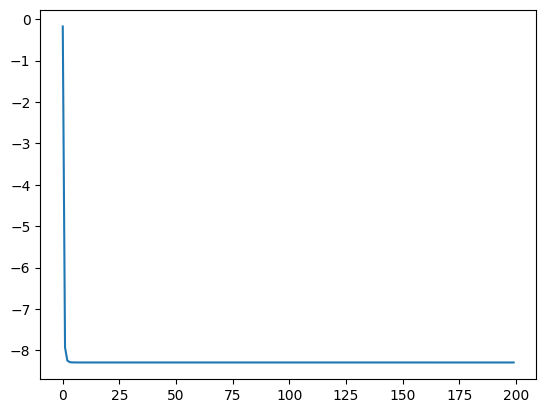

In [3]:
Lx,Ly = 4,4
NN=1

print("")
pps=np.random.rand(NN*2*Lx*Ly*4)

outC=modul_circuit_2d(pps,[Lx,Ly,NN])

# print(outC[:4,:4])

ee = fermion_VQE_2d([-1,1],[Lx,Ly,NN])
print(ee)

pl.plot(ee)
pl.show